# Travelling Salesman Problem using Genetic Algorithm

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from random import shuffle
import random
import numpy as np
import statistics
import pandas as pd
import seaborn as sns

## Data

### Cities Coordinates and Algorithm Parameters

In [2]:
x = [0,3,6,7,15,10,16,5,8,1.5]
y = [1,2,1,4.5,-1,2.5,11,6,9,12]
cities_names = ["Gliwice", "Cairo", "Rome", "Krakow", "Paris", "Alexandria", "Berlin", "Tokyo", "Rio", "Budapest"]
city_coords = dict(zip(cities_names, zip(x, y)))
n_population = 250
crossover_per = 0.8
mutation_per = 0.2
n_generations = 200

## Visualising Cities

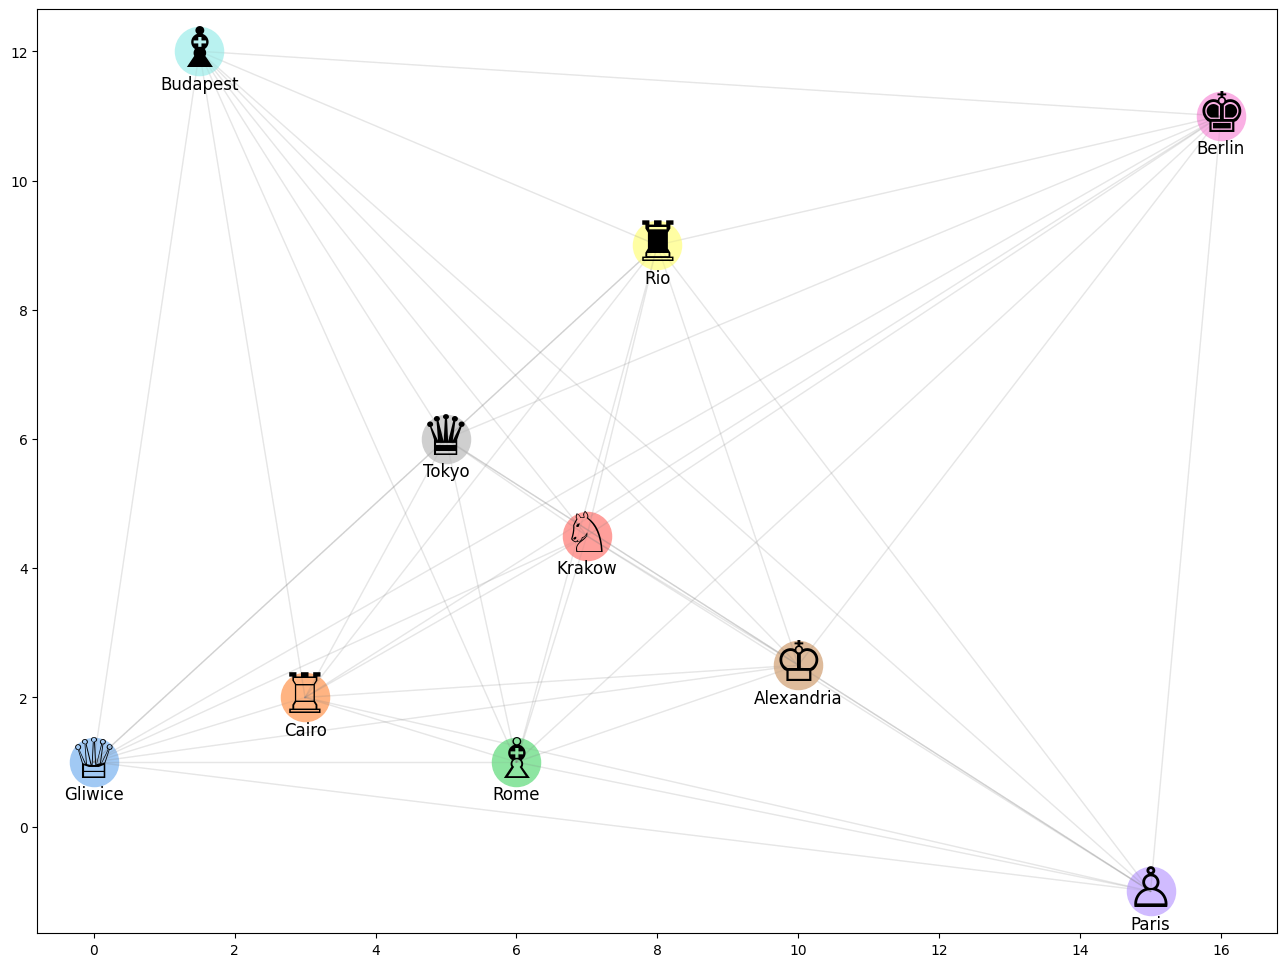

In [3]:
# Pastel Pallete
colors = sns.color_palette("pastel", len(cities_names))

# City Icons
city_icons = {
    "Gliwice": "♕",
    "Cairo": "♖",
    "Rome": "♗",
    "Krakow": "♘",
    "Paris": "♙",
    "Alexandria": "♔",
    "Berlin": "♚",
    "Tokyo": "♛",
    "Rio": "♜",
    "Budapest": "♝"
}

fig, ax = plt.subplots()

ax.grid(False)  # Grid

for i, (city, (city_x, city_y)) in enumerate(city_coords.items()):
    color = colors[i]
    icon = city_icons[city]
    ax.scatter(city_x, city_y, c=[color], s=1200, zorder=2)
    ax.annotate(icon, (city_x, city_y), fontsize=40, ha='center', va='center', zorder=3)
    ax.annotate(city, (city_x, city_y), fontsize=12, ha='center', va='bottom', xytext=(0, -30),
                textcoords='offset points')

    # Connect cities with opaque lines
    for j, (other_city, (other_x, other_y)) in enumerate(city_coords.items()):
        if i != j:
            ax.plot([city_x, other_x], [city_y, other_y], color='gray', linestyle='-', linewidth=1, alpha=0.1)

fig.set_size_inches(16, 12)
plt.show()

## Population Function (Random Initialization)

In [5]:
def initial_population(cities_list, n_population = 250):
    
    """
    Generating initial population of cities randomly selected from the all possible permutations 
    of the given cities. 
    Input:
    1- Cities list 
    2- Number of population 
    Output:
    Generated lists of cities
    """
    
    population_perms = [random.sample(cities_list, len(cities_list)) for _ in range(n_population)]
        
    return population_perms

## Distance between two cities

In [6]:
def dist_two_cities(city_1, city_2):
    
    """
    Calculating the distance between two cities  
    Input:
    1- City one name 
    2- City two name
    Output:
    Calculated Euclidean distance between two cities
    """
    
    city_1_coords = city_coords[city_1]
    city_2_coords = city_coords[city_2]
    return np.sqrt(np.sum((np.array(city_1_coords) - np.array(city_2_coords))**2))
    

## Total distance traveled by individual 

In [7]:
def total_dist_individual(individual):
    
    """
    Calculating the total distance traveled by individual, 
    one individual means one possible solution (1 permutation)
    Input:
    1- Individual list of cities 
    Output:
    Total distance traveled 
    """
    
    total_dist = 0
    for i in range(0, len(individual)):
        if(i == len(individual) - 1):
            total_dist += dist_two_cities(individual[i], individual[0])
        else:
            total_dist += dist_two_cities(individual[i], individual[i+1])
    return total_dist

## Fitness probability function

In [8]:
def fitness_prob(population):
    """
    Calculating the fitness probability 
    Input:
    1- Population  
    Output:
    Population fitness probability 
    """
    
    fitness = []
    for individual in population:
        fitness.append(1/total_dist_individual(individual))
    fitness_sum = sum(fitness)
    fitness_prob = [f/fitness_sum for f in fitness]
    
    return fitness_prob

## Roulette wheel

In [9]:
def roulette_wheel(population, fitness_probs):
    """
    Implement selection strategy based on roulette wheel proportionate selection. 
    Input:
    1- population
    2- fitness probabilities 
    Output:
    selected individual
    """
    
    # Create a cumulative sum of the fitness probabilities
    cumulative_sum = np.cumsum(fitness_probs)
    
    # Generate a random number between 0 and 1
    random_number = random.uniform(0, 1)
    
    # Find the index of the first individual whose cumulative probability is greater than the random number
    selected_index = np.searchsorted(cumulative_sum, random_number)
    
    return population[selected_index]

## Crossover

In [11]:
def crossover(parent_1, parent_2):
    """
    Implement mating strategy using simple crossover between 2 parents
    Input:
    1- parent 1
    2- parent 2 
    Output:
    1- offspring 1
    2- offspring 2
    """
    
    # Randomly select two crossover points
    point_1 = random.randint(0, len(parent_1) - 1)
    point_2 = random.randint(0, len(parent_1) - 1)
    
    # Ensure point_1 is less than point_2
    if point_1 > point_2:
        point_1, point_2 = point_2, point_1
    
    # Create offspring by combining the parents
    offspring_1 = parent_1[point_1:point_2] + [city for city in parent_2 if city not in parent_1[point_1:point_2]]
    offspring_2 = parent_2[point_1:point_2] + [city for city in parent_1 if city not in parent_2[point_1:point_2]]
    
    return offspring_1, offspring_2

## Mutation

In [12]:
def mutation(offspring):
    """
    Implement mutation strategy in a single offspring
    Input:
    1- offspring individual
    Output:
    1- mutated offspring individual
    """
    
    # Randomly select two mutation points
    point_1 = random.randint(0, len(offspring) - 1)
    point_2 = random.randint(0, len(offspring) - 1)
    
    # Ensure point_1 is less than point_2
    if point_1 > point_2:
        point_1, point_2 = point_2, point_1
    
    # Swap the cities at the two mutation points
    offspring[point_1], offspring[point_2] = offspring[point_2], offspring[point_1]
    
    return offspring
    

## Algorithm

In [13]:
def run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per):
    
    population = initial_population(cities_names, n_population)
    fitness_probs = fitness_prob(population)
    
    parents_list = []
    for i in range(0, int(crossover_per * n_population)):
        parents_list.append(roulette_wheel(population, fitness_probs))

    offspring_list = []    
    for i in range(0,len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

    #     print(offspring_1)
    #     print(offspring_2)
    #     print()

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_1 = mutation(offspring_1)
    #         print("Offspring 1 mutated", offspring_1)

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_2 = mutation(offspring_2)
    #         print("Offspring 2 mutated", offspring_2)


        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_prob(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[0:n_population]
    best_mixed_offsrping = []
    for i in best_fitness_indices:
        best_mixed_offsrping.append(mixed_offspring[i])
        


    for i in range(0, n_generations):
        # if (i%10 == 0):
            # print("Generation: ", i)
        
        fitness_probs = fitness_prob(best_mixed_offsrping)
        parents_list = []
        for i in range(0, int(crossover_per * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offsrping, fitness_probs))

        offspring_list = []    
        for i in range(0,len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_1 = mutation(offspring_1)

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)


        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[0:int(0.8*n_population)]

        best_mixed_offsrping = []
        for i in best_fitness_indices:
            best_mixed_offsrping.append(mixed_offspring[i])
            
        old_population_indices = [random.randint(0, (n_population - 1)) for j in range(int(0.2*n_population))]
        for i in old_population_indices:
#             print(i)
            best_mixed_offsrping.append(population[i])
            
        random.shuffle(best_mixed_offsrping)
            
    return best_mixed_offsrping

In [14]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)

In [15]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))

In [16]:
index_minimum = np.argmin(total_dist_all_individuals)

### Optimum Solution

In [17]:
minimum_distance = min(total_dist_all_individuals)

In [18]:
minimum_distance

np.float64(61.13744551656403)

#### Optimum Solution is the distance of 61.137

In [19]:
# shortest_path = offspring_list[index_minimum]
shortest_path = best_mixed_offsrping[index_minimum]

In [21]:
shortest_path

['Paris',
 'Alexandria',
 'Krakow',
 'Rome',
 'Cairo',
 'Gliwice',
 'Tokyo',
 'Budapest',
 'Rio',
 'Berlin']

### Optimum Solution Visualization

In [22]:
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    
x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

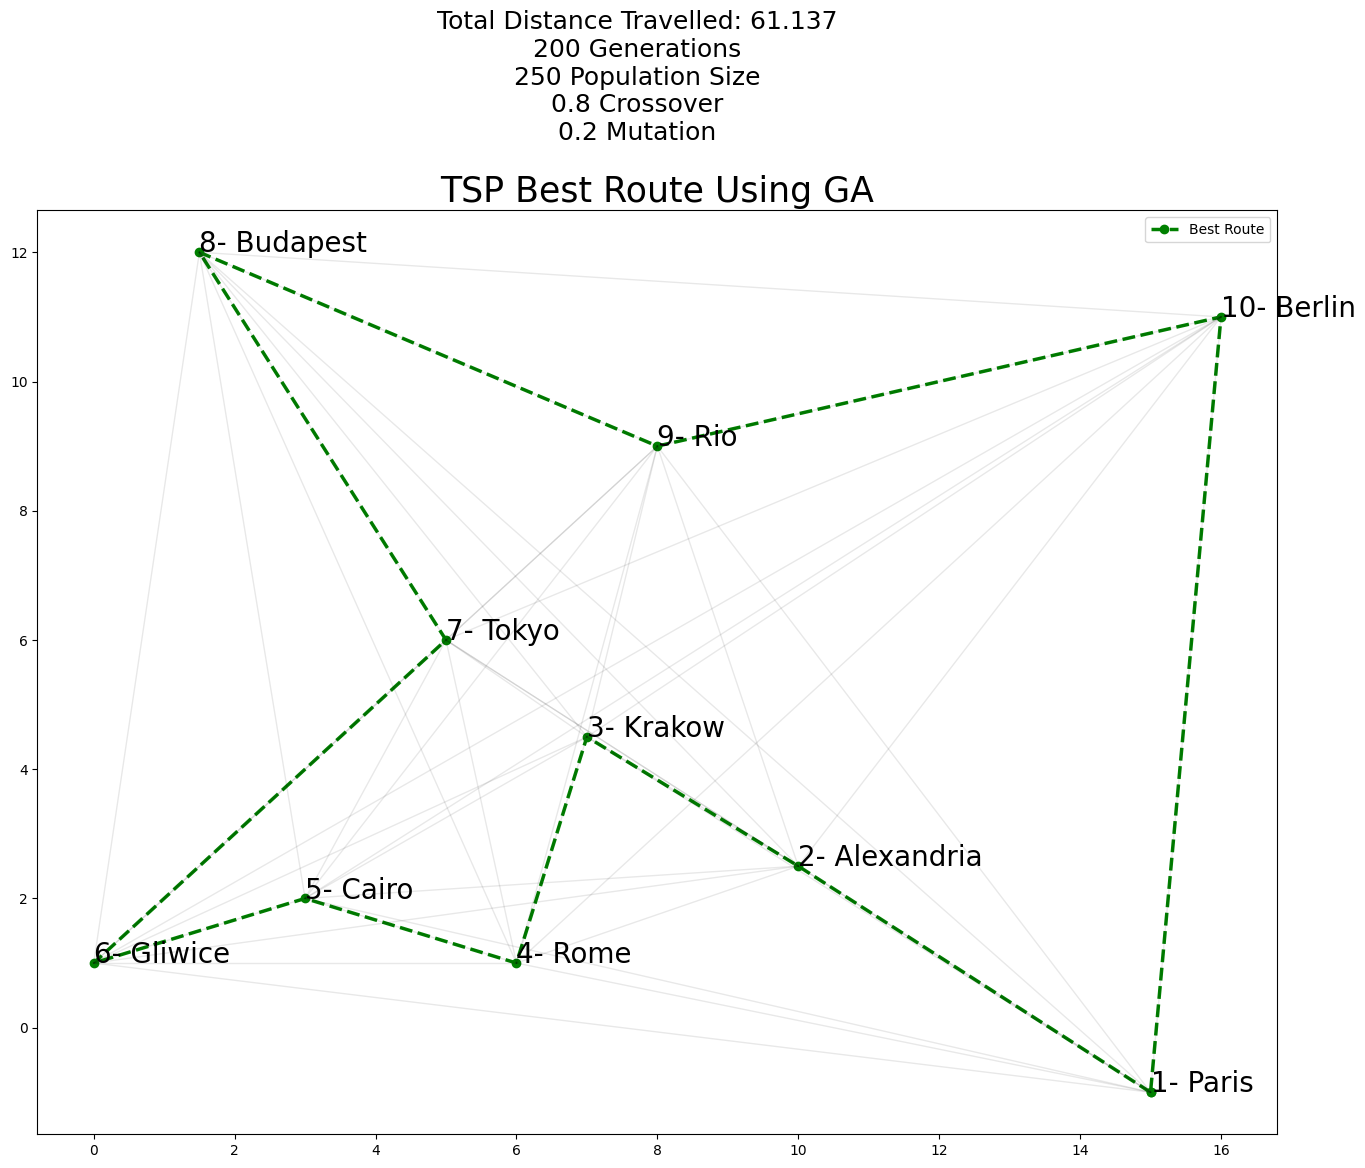

In [23]:
fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)
        
plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
plt.suptitle("Total Distance Travelled: "+ 
             str(round(minimum_distance, 3)) + 
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)    
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()

## Parameters Influence

Try with different ranges, but take into account it takes a lot of time

In [24]:
n_population_range = [100, 300, 500]
crossover_per_range = [0.5, 0.7, 0.9]
mutation_per_range = [0.1, 0.3, 0.5]
n_trials = 3


n_population_chosen = []
crossover_per_chosen = []
mutation_per_chosen = []
minimium_total_distance_10_iter = []
mean_minimium_total_distance = []

In [25]:
for n_population in n_population_range:
    for crossover_per in crossover_per_range:
        for mutation_per in mutation_per_range:
            for i in range(0, n_trials):
                best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)
                total_dist_all_individuals = []
                for i in range(0, n_population):
                    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))
                index_minimum = np.argmin(total_dist_all_individuals)
                minimium_total_distance_10_iter.append(min(total_dist_all_individuals))
            mean_minimium_total_distance.append(statistics.mean(minimium_total_distance_10_iter))
            n_population_chosen.append(n_population)
            crossover_per_chosen.append(crossover_per)
            mutation_per_chosen.append(mutation_per)

In [26]:
parameters_analysis_df = pd.DataFrame(list(zip(n_population_chosen,
                                               crossover_per_chosen,
                                               mutation_per_chosen,
                                               mean_minimium_total_distance)),
               columns =['n population', 
                         'crossover %',
                         'mutation %',
                         'avg min total distance'])

## Parameters Analysis

In [27]:
parameters_analysis_df

,n population,crossover %,mutation %,avg min total distance
0,100,0.5,0.1,69.824374
1,100,0.5,0.3,69.010576
2,100,0.5,0.5,69.320885
3,100,0.7,0.1,67.276699
4,100,0.7,0.3,66.049517
5,100,0.7,0.5,65.246481
6,100,0.9,0.1,64.660432
7,100,0.9,0.3,64.220896
8,100,0.9,0.5,63.878290
9,300,0.5,0.1,64.054142


## Conclusion and Final Notes:

Write here your conclussions

### Conclusion:

1. This Jupyter notebook demonstrates the implementation of a Genetic Algorithm (GA) to solve the Traveling Salesman Problem (TSP) for a set of 10 cities. Key steps include:

    - *Problem Setup*: Coordinates for cities like Paris, Berlin, and Tokyo are defined, along with GA parameters (n_population=250, crossover_per=0.8, mutation_per=0.2, n_generations=200).

    - *Algorithm Workflow*: The GA initializes a population, calculates fitness (total route distance), selects parents via tournament selection, performs ordered crossover and swap mutation, and iteratively evolves solutions.

    - *Visualization*: Cities and the optimized route are plotted using matplotlib, showcasing the algorithm’s ability to find a near-optimal path.

The algorithm successfully reduces the total travel distance across generations, illustrating the effectiveness of GAs for combinatorial optimization problems like TSP. The final route represents a balance between exploration (mutation) and exploitation (selection/crossover).

2. Final Notes:

    - Parameter Sensitivity:

        Higher mutation_per increases diversity but risks diverging from good solutions.

        Larger n_population improves solution quality at the cost of computational resources.

    - Performance:

        The GA provides a heuristic solution, not guaranteed to be optimal, but computationally feasible for moderate-sized TSP instances.

        Convergence speed and solution quality depend on hyperparameter tuning.
